In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy
from nltk.stem import PorterStemmer

### Считываем данные

In [4]:
data = pd.read_csv('german_labeled.txt', sep=' ==> ', header=None)
data.columns = ['date', 'country', 'party', 'text', 'code']
print(data.shape)
data.head()

/Users/yuser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(125421, 5)


,date,country,party,text,code
0,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"Liebe Wählerinnen, liebe Wähler,",NaN
1,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,dieses Wahlprogramm haben wir für Sie geschrie...,NaN
2,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"Grüne Ideen stehen für eine andere Politik, di...",NaN
3,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,Wir wollen Luxemburg zu einer offeneren Gesell...,NaN
4,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"Dieses Programm ist ein Kompass, der die Orien...",NaN


In [45]:
data.code.unique().shape

(56,)

Приведем лейблы к целочисленной форме (отбросим часть после точки, где надо). Классы с нестандартной разметкой типа "0", "000", "H" удалим.

In [5]:
data = data[data.text.notnull()]
data = data[(data.code!='0')&(data.code!='000')&(data.code!='H')&(data.code.notnull())]
data['code'] = data.code.apply(lambda x: int(float(x)))
data.code.unique().shape

(56,)

In [6]:
data.code.unique()

array([202, 503, 304, 201, 705, 706, 301, 204, 303, 411, 504, 505, 606,
       506, 401, 108, 604, 605, 607, 608, 110, 107, 302, 403, 416, 501,
       414, 305, 409, 703, 402, 701, 404, 405, 408, 601, 410, 603, 507,
       412, 502, 413, 104, 103, 106, 105, 407, 406, 704, 203, 415, 702,
       109, 101, 602, 102])

Напишем функции для токенизации, удаления стоп-слов, стемминга.

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def stemming(text):
    out = []
    for word in text:
        out.append(PorterStemmer().stem(word))
    return out

Загрузим стоп-слова в переменную stop_words.

In [8]:
stop_words = stopwords.words('german')

Сделаем токенизацию.

In [9]:
data['text'] = list(sent_to_words(data.text))
data.head()

,date,country,party,text,code
12,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[wir, wollen, in, einer, modernen, gesellschaf...",202
13,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[wir, wollen, eine, offene, gesellschaft, die,...",503
14,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[wir, wollen, unsere, demokratie, wiederbeleben]",202
15,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[das, beginnt, damit, dass, offentliche, verwa...",202
16,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[wir, diese, starker, in, politische, entschei...",202


Сделаем стемминг, результатами заменим содержание столбца 'text'.

In [10]:
data['text'] = data.text.apply(stemming)
data.text.head(15)

12    [wir, wollen, in, einer, modernen, gesellschaf...
13    [wir, wollen, ein, offen, gesellschaft, die, a...
14       [wir, wollen, unser, demokrati, wiederbeleben]
15    [da, beginnt, damit, dass, offentlich, verwalt...
16    [wir, dies, starker, in, politisch, entscheidu...
17    [wir, mochten, auch, die, angestaubten, politi...
18    [die, letzten, monat, haben, die, politisch, l...
19    [die, burgerinnen, und, burger, luxemburg, suc...
20    [politik, braucht, ideal, wert, und, ziel, dam...
21    [regierend, die, sich, zu, sehr, vom, alltag, ...
22    [deshalb, wollen, wir, die, demokrati, starken...
24    [dei, greng, wollen, da, vertrauen, der, burge...
25    [politisch, verantwortung, darf, nicht, zu, ei...
26    [institutionen, und, verwaltungen, sollen, der...
27    [wir, wollen, mehr, transparenz, und, effizien...
Name: text, dtype: object

Удалим стоп-слова.

In [11]:
data['text'] = remove_stopwords(data['text'])
data.head()

,date,country,party,text,code
12,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[modernen, gesellschaft, starken, demokrati, l...",202
13,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[offen, gesellschaft, all, gleichermaßen, einb...",503
14,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[demokrati, wiederbeleben]",202
15,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[beginnt, dass, offentlich, verwaltungen, dien...",202
16,200406,Luxembourg,Socialist Workers’ Party of Luxembourg,"[starker, politisch, entscheidungen, einbinden]",202


Удалим опустевшие после проделанных операций строки таблицы

In [12]:
data = data[data.text.apply(tuple)!=()]

Создадим словарь, ключами в котором будут лейблы, а значениями – объединенные списки слов из относящихся к лейблу предложений.

In [13]:
tag_dict = dict()
for i in data.index:
    if not data.code.loc[i] in tag_dict:
        tag_dict[data.code.loc[i]] = []
    tag_dict[data.code.loc[i]].extend(data.text.loc[i])

Объединим списки слов в строки для использования TfidfVectorizer.

In [14]:
joined = [' '.join(x) for x in tag_dict.values()]

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

Построим матрицу tf.icf.

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_data = tfidf.fit_transform(joined)
tfidf_data.shape

(56, 619022)

Опишем функции для взвешивания слов, согласно методу Мерца.

In [17]:
def count_text(line):
    text = data.text.loc[line]
    res = np.zeros((1,tfidf_data.shape[1]))
    for word in text:
        res[0, tfidf.vocabulary_[word]] += 1
    return res

In [18]:
def vectorizing(line):
    res = 1/2 * count_text(line)
    if (line - 1) in data.index and data.party.loc[line] == data.party.loc[line-1] and data.date.loc[line] == data.date.loc[line-1]:
        res += 1/6 * count_text(line-1)
        
        if (line - 2) in data.index and data.party.loc[line] == data.party.loc[line-2] and data.date.loc[line] == data.date.loc[line-2]:
            res += 1/12 * count_text(line-2)
        else: res += 1/12 * count_text(line)
            
    else: res += 1/4 * count_text(line)
    if (line + 1) in data.index and data.party.loc[line] == data.party.loc[line+1] and data.date.loc[line] == data.date.loc[line+1]:
        res += 1/6 * count_text(line+1)
            
        if (line + 2) in data.index and data.party.loc[line] == data.party.loc[line+2] and data.date.loc[line] == data.date.loc[line+2]:
            res += 1/12 * count_text(line+2)
        else: res += 1/12 * count_text(line)
    else: res += 1/4 * count_text(line)
    
    return res

In [19]:
data.index = range(data.shape[0])

In [20]:
def final_vect(line):
    return tfidf_data.dot(vectorizing(line).T).reshape(data.code.unique().shape[0])

Построим векторы признаков

In [20]:
features = np.zeros((data.shape[0],tfidf_data.shape[0]))
features.shape

(113529, 56)

In [22]:
"""for i in data.index:
    print(i)
    features[i,:] = final_vect(i)
features.shape"""

'for i in data.index:\n    print(i)\n    features[i,:] = final_vect(i)\nfeatures.shape'

Возьмем уже построенные векторы признаков из файла.

In [57]:
features = pd.read_csv('vect_56_len_bigram.csv', header=None, sep=' ')
features.shape

(113529, 56)

Добавим к ним столбец с лейблами.

In [59]:
features = pd.DataFrame(features)
features['code'] = data.code

In [58]:
np.sum(data.code.isnull())

0

Добавим столбец, позволяющий идентифицировать каждый отдельный документ

In [60]:
data['doc'] = data.date.apply(str) + data.party + data.country
features['doc'] = data.doc

## Обучение моделей

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

In [25]:
features.doc.unique().shape

(88,)

Выбор тестовых документов.

In [61]:
#germ2013 = data[(data.country=='Germany')&(data.date>201300)&(data.date<201400)]
data2017 = data[(data.date>201700)&(data.date<201800)]
selected = []

In [62]:
data[(data.date>201700)&(data.date<201800)].doc.unique()

array(['201709Alliance‘90/GreensGermany', '201709The LeftGermany',
       '201709Social Democratic Party of GermanyGermany',
       '201709Free Democratic PartyGermany',
       '201709Christian Democratic Union/Christian Social UnionGermany',
       '201709Alternative for GermanyGermany'], dtype=object)

In [63]:
data2017.doc.shape

(8663,)

In [ ]:
"""while (np.sum(data.doc.apply(lambda x: x in selected))) < 10000:
    selected = np.random.choice(data2017.doc.unique(), size=(6))
    np.sum(data.doc.apply(lambda x: x in selected))"""

In [ ]:
#np.sum(data.doc.apply(lambda x: x in selected))

In [64]:
data.index = range(data.shape[0])
features.index = range(features.shape[0]);

Разобьем выборку на тренировочную и тестовую.

In [65]:
np.sum(features.code.isnull())

0

In [66]:
test_ind = data.doc.apply(lambda x: x in data2017.doc.unique())
y_test = features.code[test_ind]
y_train = features.code[test_ind == False]
X_test = features.drop(['code', 'doc'], axis=1)[test_ind]
X_train = features.drop(['code', 'doc'], axis=1)[test_ind == False]
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((8663, 56), (8663,), (104866, 56), (104866,))

In [67]:
features.code[test_ind]

73856    305
73857    414
73858    414
73859    408
73860    410
73861    603
73862    504
73863    506
73864    411
73865    506
73866    411
73867    601
73868    107
73869    107
73870    305
73871    305
73872    305
73873    305
73874    403
73875    107
73876    107
73877    305
73878    601
73879    305
73880    408
73881    305
73882    305
73883    410
73884    408
73885    305
        ... 
82489    501
82490    501
82491    501
82492    501
82493    501
82494    703
82495    109
82496    303
82497    401
82498    501
82499    703
82500    703
82501    703
82502    703
82503    703
82504    301
82505    301
82506    110
82507    403
82508    403
82509    403
82510    403
82511    403
82512    703
82513    703
82514    703
82515    703
82516    303
82517    412
82518    412
Name: code, Length: 8663, dtype: int64

### GridSearch на SVC

In [80]:
parameters = {
    'C': [0.25, 0.5, 1, 2, 4],
    'kernel': ['linear', 'rbf','poly']
}
svm = GridSearchCV(SVC(), parameters, n_jobs=-1)
svm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.25, 0.5, 1, 2, 4], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [81]:
svm_pred = svm.best_estimator_.predict(X_test)

In [68]:
f1_score(y_true=y_test, y_pred=svm_pred, average='micro')

0.46288814498441649

In [95]:
svm_pred.columns = ['code']

In [98]:
y_test = pd.DataFrame(y_test.apply(float))

In [102]:
np.sum(y_test==svm_pred) / len(y_test)

code    0.462888
dtype: float64

In [79]:
y_test.index = range(len(y_test))

In [84]:
np.savetxt('svm_stem_pred_2017.csv', svm_pred)

In [19]:
svm_pred = pd.read_csv('svm_stem_pred_2017.csv', header=None)

### Графики

In [156]:
from collections import Counter
import matplotlib.pyplot as plt

#### SVM

In [116]:
x = features.doc[test_ind]
x.index = range(len(x))

In [141]:
plt.show()

In [120]:
svm_pred['doc'] = x
y_test['doc'] = x
pc = []
yc = []
for i in data.doc.unique():
    for j in data.code.unique():
        pc.append(svm_pred[(svm_pred.doc==i)&(svm_pred.code==j)].shape[0])
        yc.append(y_test[(y_test.doc==i)&(y_test.code==j)].shape[0])

Text(0.5,1,'ff')

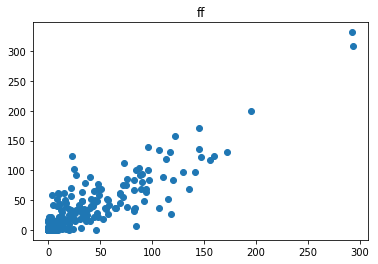

In [157]:
plt.scatter(x=np.array(pc), y=np.array(yc))
plt.title('x - computer-annotated')

Оценим среднеквадратичное отклонение наших предсказаний от фактических значений. Посчитаем корреляцию между ними.

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
mean_squared_error(y_pred=pc, y_true=yc)

26.279626623376622

In [90]:
pd.DataFrame(pc).corrwith(pd.DataFrame(yc))

0    0.919148
dtype: float64